In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [3]:
graph_file = 'data/graphs/400950-400951_n5.json'

cuda:0


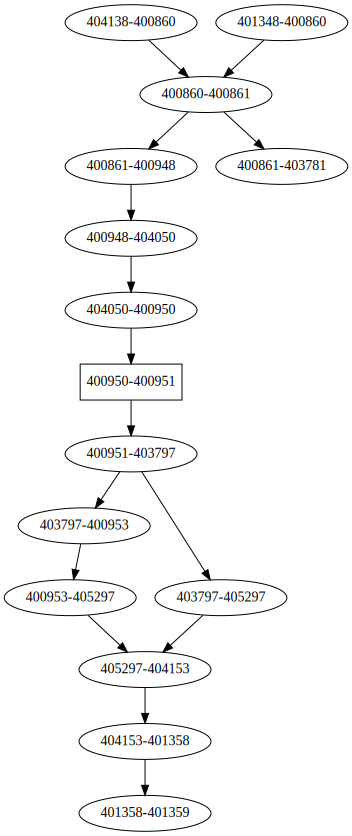

In [4]:
SROUTE, ADJ = read_graph(graph_file, 
                         verbose=False, named_adj=True)
# SROUTE, ADJ = complete_graph(SROUTE, ADJ)
graph = show_graph(SROUTE, ADJ)

DENSE = False
EPS = 60
LAG = 25 + 1
# LAG = 60 + 1
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
graph

In [5]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
valset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 26)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [403797-400953]: 90
    * [400948-404050]: 90
    * [403797-405297]: 90
    * [405297-404153]: 90
    * [400861-400948]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [404153-401358]: 90
    * [400861-403781]: 90
    * [401358-401359]: 90
    * [404138-400860]: 90
    * [401348-400860]: 90
 [*] Examples (train): 4327
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 26)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [403797-400953]: 90
    * [400948-404050]: 90
    * [403797-405297]: 90
    * [405297-404153]: 90
    * [400861-400948]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [404153-401358]: 90
    * [400861-403781]: 90
    * [401358-401359]: 90
    * [404138-400860]: 90
    * [401348-400860]: 90
 [*] Examples (test): 1157
 [*] Time range: 2014-08-01 ~ 2014-10-

In [6]:
from models.temporal.RNN import *

HSIZE = 256

model = RNN_FCAST(SROUTE, ADJ, hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
# batch x timesteps x location
evf = lambda: evaluate(
    valset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 11.5894          


In [9]:
losses = []
eval_mse = []
eval_mape = []

In [10]:
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
        

    sys.stdout.write('\n')
    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/60 : 136/136] - L1.30 (avg 3.26)      
Eval loss: 0.8047          
[2/60 : 136/136] - L0.17 (avg 0.42)      
Eval loss: 0.3848          
[3/60 : 136/136] - L0.15 (avg 0.18)      
Eval loss: 0.2597          
[4/60 : 136/136] - L0.13 (avg 0.14)      
Eval loss: 0.2247          
[5/60 : 136/136] - L0.11 (avg 0.11)      
Eval loss: 0.1982          
[6/60 : 136/136] - L0.10 (avg 0.10)      
Eval loss: 0.2051          
[7/60 : 136/136] - L0.08 (avg 0.09)      
Eval loss: 0.2327          
[8/60 : 136/136] - L0.09 (avg 0.08)      
Eval loss: 0.1765          
[9/60 : 136/136] - L0.06 (avg 0.07)      
Eval loss: 0.2043          
[10/60 : 136/136] - L0.05 (avg 0.07)      
Eval loss: 0.1615          
[11/60 : 136/136] - L0.07 (avg 0.07)      
Eval loss: 0.1573          
[12/60 : 136/136] - L0.07 (avg 0.07)      
Eval loss: 0.2045          
[13/60 : 136/136] - L0.06 (avg 0.06)      
Eval loss: 0.1530          
[14/60 : 136/136] - L0.06 (avg 0.06)      
Eval loss: 0.1469          
[15/60 : 136/13

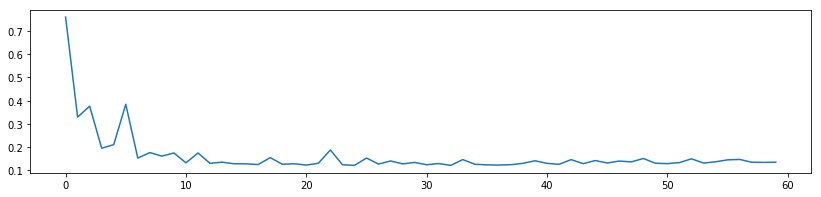

In [11]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [12]:
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)

Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [403797-400953]: 90
    * [400948-404050]: 90
    * [403797-405297]: 90
    * [405297-404153]: 90
    * [400861-400948]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [404153-401358]: 90
    * [400861-403781]: 90
    * [401358-401359]: 90
    * [404138-400860]: 90
    * [401348-400860]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [17]:
sqerr = eval_rnn(testset, model, plot=False)
print('Eval segments:', len(testset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.1125


Using fringes: 4


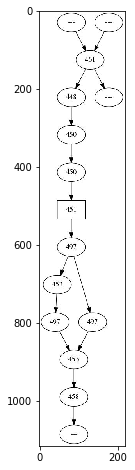

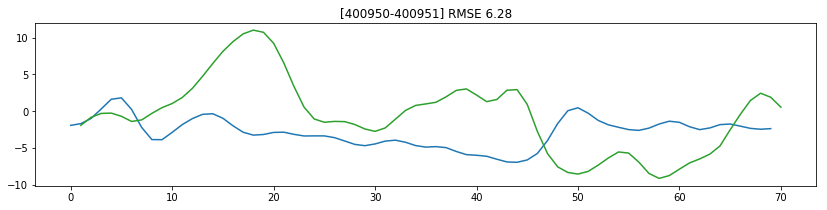

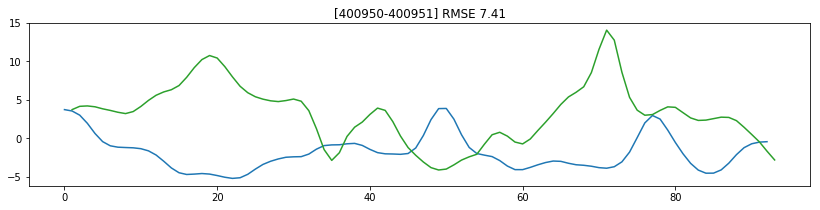

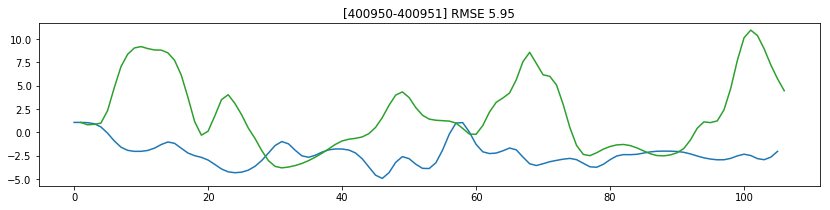

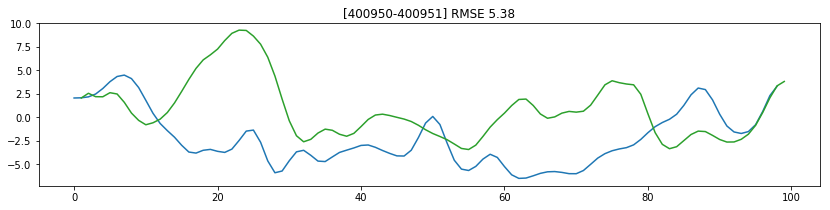

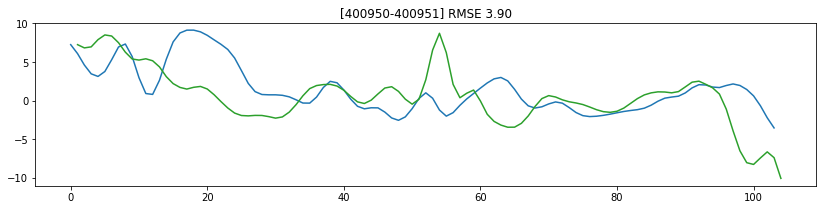

In [13]:
for ii in range(5):
    _ = forecast_rnn(
        testset[ii], model, graph_file, 
        verbose=ii==0, twoway=True, plot=True)

In [17]:
sname = 'checkpoints/rnn_%s_h1.pth' % ('thin' if not DENSE else 'dense')
sname

'checkpoints/rnn_dense_h1.pth'

In [18]:
# torch.save(
#     model.state_dict(), 
#     sname)